In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
from risk_model import Model, pct_change, scale_0_1
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp


float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

tf.random.set_seed(123)
np.random.seed(123)

tf.get_logger().setLevel('ERROR')

fillna_const = 1.0

In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

In [3]:
#calculates potfolio statistics based on allocation
#input alloc - allocation array, stock_close - dataframe with close prices
def calc_portfolio_values(alloc, stock_close):
    pct = np.divide(stock_close, stock_close[0])
    portfolio_values = np.sum(pct * alloc, axis=1)
    portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]
    sharpe = np.mean(portfolio_returns) / np.std(portfolio_returns)
    return np.sum(portfolio_returns ), np.std(portfolio_returns), sharpe


def print_portfolio_values(alloc, stock_close):
    pr, pstd, psharp = calc_portfolio_values(alloc, stock_close)
    print('portfolio_returns: {:.4f}'.format(pr))
    print('std: {:.4f}'.format(pstd))
    print('sharpe: {:.4f}'.format( psharp ))

@tf.function
def prep_scale(data):
    data = tf.cast(data, tf.float32)
    data = (data-tf.reduce_min(data, axis=0))/(tf.reduce_max(data, axis=0)-tf.reduce_min(data, axis=0) + 0.000000001)
    return data

@tf.function
def prep_cov(data):
    data = tf.cast(data, tf.float32)
    data = tfp.stats.covariance(data)
    return data

@tf.function
def prep_pct_chg(data):
    data = tf.transpose(data)
    data = tf.experimental.numpy.diff(data)/data[:,:-1]
    data = tf.transpose(data)
    data = tf.cast(data, tf.float32)
    data = tf.concat([tf.zeros([1,tf.shape(data)[1]]), data], axis=0)
    return data

@tf.function
def preprocessDataElement(x_data):
    x = np.concatenate([ scale_0_1(x_data)[1:], pct_change(x_data)[1:] ], axis=1)
    return x

@tf.function
def preprocessInputData(data, labels=None):
    pct = prep_pct_chg(data)
    data_scaled = prep_scale(data)
    return (tf.concat([data_scaled, pct],1), labels)

@tf.function
def prep_random_col(data, labels = None):
    idx = tf.random.shuffle(tf.range(tf.shape(data)[1]))
    dt = tf.gather(data, idx,axis=1)
    if labels is not None:
        lb = tf.gather(labels, idx,axis=0)
    return (dt, lb)


def getOneTrainElement(X_data, m1_train_start, m1_train_n, m2_train_n, retrain_n = 2):
    '''
    X_data - price data frame
    m1_train_start - start of trainings data
    m1_train_n - number of trainings data
    m2_train_n - number of data for y calculation 
    '''
    train_m1_x = X_data[m1_train_start:m1_train_start+m1_train_n]
    if(m2_train_n > 0):
        train_m2_x = X_data[m1_train_start+m1_train_n:m1_train_start+m1_train_n+m2_train_n]
    else:
        return train_m1_x, None, None

    _param={}
    _param ={'model_params':
        {'model_n':'LSTM',
        'epochs':1000}}
    if(retrain_n > 1):
        _y = []
        _sharp = []
        for i in range(retrain_n):
            risk_model = Model()
            _y.append( risk_model.get_allocations(train_m2_x, **_param['model_params']) )
            _p, _s, _sp = calc_portfolio_values(_y[-1],train_m2_x)
            _sharp.append(_sp)
        i = np.argmax(_sharp)
        train_m1_y = _y[i]
    else:
        risk_model = Model()
        train_m1_y = risk_model.get_allocations(train_m2_x, **_param['model_params'])
    return train_m1_x, train_m1_y, train_m2_x



def dataGenerator(X_data, m1_train_n, m2_train_n, retrain_n = 0, n = 2): 
    i = 0
    rnd_rand = X_data.shape[0] - m1_train_n - m2_train_n - 1
    if(rnd_rand < 1):
        print("ERROR: Wrong data")
        return 
    g = tf.random.Generator.from_seed(42)    
    starts = g.uniform(shape=(n,), dtype=tf.int32, minval=0, maxval=rnd_rand)
    for m1_train_start in starts:
        print(m1_train_start)
        X, y, _k = getOneTrainElement(X_data, m1_train_start, m1_train_n, m2_train_n, retrain_n)
        yield (X, y)


# Generate and Store DataSet

Generate data for next period

In [4]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']

history_range = {'start': datetime(2000, 1, 1), 
                 'end': datetime(2006, 12, 31)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')
stock_close = stock.iloc[:]['Close'].reset_index(drop=True).fillna(fillna_const)                

In [5]:
ds_counter = tf.data.Dataset.from_generator(dataGenerator, args=[stock_close.values, 125, 22, 0, 1400], 
output_types=(tf.float32, tf.float32), output_shapes=((None, None), (None,)) )

In [6]:
path = "./saved_data_tmp"
dataset = ds_counter.take(1)
tf.data.experimental.save(dataset, path)

tf.Tensor(690, shape=(), dtype=int32)


In [7]:
# load and test
new_dataset = tf.data.experimental.load(path,element_spec=(tf.TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

for i, elem in enumerate(new_dataset.take(1)):
    print(elem)

(<tf.Tensor: shape=(125, 10), dtype=float32, numpy=
array([[22.4000, 3.6300, 285.1000, ..., 41.8700, 1092.4000, 42.2200],
       [21.8850, 3.5100, 279.8000, ..., 41.1000, 1054.0000, 41.4400],
       [22.0250, 3.2000, 267.3000, ..., 41.2700, 1049.0000, 38.9000],
       ...,
       [24.2100, 6.1800, 344.5000, ..., 39.0500, 989.0000, 47.8300],
       [24.3500, 6.3800, 356.0000, ..., 39.1900, 1012.0000, 48.0500],
       [25.7200, 7.0000, 370.4000, ..., 39.3000, 1060.4000, 49.1200]],
      dtype=float32)>, <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2199, 0.7801,
       0.0000, 0.0000], dtype=float32)>)


# Network

In [8]:
class TfModel():
    def __init__(self, input_shapes, output_shape, load_path=None, model_nr = 0):
        self.model = None
        self.history = None

        if model_nr == 1:
            self._build_model1(input_shapes, output_shape)
        elif model_nr == 2:
            self._build_model2(input_shapes, output_shape)
        else:
            self._build_model(input_shapes, output_shape)

        if load_path is not None:
            self.loadModel(load_path)

        pass

    def _build_model(self, input_shapes, output_shape):
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')
        L = layers.LSTM(128)(input_price)
        L = layers.Dense(48, activation='relu')(L)
        L =layers.Dropout(0.5)(L)
        #L = layers.Flatten()(L)
        out = layers.Dense(output_shape, activation='softmax')(L)

        self.model = tf.keras.Model(inputs=input_price, outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              loss='mse', 
              metrics=['accuracy'])
        pass

    def _build_model1(self, input_shapes, output_shape):
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')
        L = layers.LSTM(64)(input_price)
        L = layers.Dense(24, activation='relu')(L)
        L =layers.Dropout(0.5)(L)
        L = layers.Flatten()(L)
        out = layers.Dense(output_shape, activation='softmax')(L)

        self.model = tf.keras.Model(inputs=input_price, outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              loss='mse', 
              metrics=['accuracy'])
        pass

    def _build_model2(self, input_shapes, output_shape):
        input_cov = tf.keras.Input(shape=input_shapes['input_cov'],name='input_cov')
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')

        L = layers.LSTM(128, recurrent_dropout=0.3,)(input_price)
        L = layers.Dense(100, activation='relu')(L)
        L = layers.Dropout(0.3)(L)
        
        L2 = layers.LSTM(64, dropout=0.3,)(input_cov)
        L2 = layers.Dense(40, activation='relu')(L2)
        L2 = layers.Dropout(0.3)(L2)
        
        LO = tf.concat([L,L2],1)
        LO = layers.Dense(20, activation='relu')(LO)
        out = layers.Dense(output_shape, activation='softmax')(LO)

        self.model = tf.keras.Model(inputs=[input_price, input_cov], outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              #loss='kl_divergence', 
              loss='mse',
              metrics=['accuracy'])
        pass

    def summary(self):
        return self.model.summary()

    def trainModel(self, dataset,  n_epoch=50, batch_size=200, n_shuffle=200, n_prefetch=50, n_repeat=1, verbose = 1):
        train_ds = dataset.shuffle(n_shuffle)
        train_ds = train_ds.repeat(n_repeat)
        train_ds = train_ds.map(preprocessInputData)
        train_ds = train_ds.batch(batch_size)
        train_ds = train_ds.prefetch(n_prefetch)       
        self.history = self.model.fit(train_ds, epochs=n_epoch, verbose=verbose)
        return self.history

    def resetModel():
        pass

    def evalModel(self, dataset, batch_size=5, steps = 2):
        ds_eval = dataset.map(preprocessInputData)
        ds_eval = ds_eval.batch(batch_size)
        self.model.evaluate(ds_eval, steps=steps)
        pass
    
    def saveModel(self, path="./save_model/"):
        self.model.save(path)

    def loadModel(self, path="./save_model/"):
        self.model = tf.keras.models.load_model(path)


    def get_allocations(self, data, **param):
        m1_train_start = param['data_start_index']
        m1_train_n = param['train_period']
        m2_train_n = 0

        X, y, _k = getOneTrainElement(data, m1_train_start, m1_train_n, m2_train_n, 0)
        dataset_X = tf.data.Dataset.from_tensors(tf.cast(X,tf.float32))
        
        dataset = dataset_X.map(preprocessInputData)
        dataset = dataset.batch(1)
        alloc = self.model.predict(dataset).flatten()
        return alloc


# Train Network

In [9]:
path = "./saved_data"
new_dataset = tf.data.experimental.load(path,element_spec=(tf.TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

# path = "./saved_data_etf_2010_2015"
# new_dataset = tf.data.experimental.load(path,element_spec=(tf.TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
#  tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

In [10]:
tf.data.experimental.cardinality(new_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=1000>

In [13]:
input_shapes = {}
input_shapes['input_price'] = (125,20)
input_shapes['input_cov'] = (10,10)
model = TfModel(input_shapes,10,)# load_path="saved_model_1_078")
# n_outputs = 10

# for ETF
# input_shapes['input_price'] = (125,8)
# model = TfModel(input_shapes,4,)# load_path="saved_model_1_078")


In [14]:
_param={}
_param ={'model_params':
    {'data_start_index':0,
     'train_period':125,
     'predict_period':22}}
model.get_allocations(stock_close.values, **_param['model_params'])     

array([0.1072, 0.0929, 0.1011, 0.1083, 0.0939, 0.1072, 0.0991, 0.0969,
       0.0926, 0.1008], dtype=float32)

In [13]:
model.summary()

Model: "sharp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_price (InputLayer)     [(None, 125, 8)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                6192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 196       
Total params: 76,532
Trainable params: 76,532
Non-trainable params: 0
_________________________________________________________________


In [14]:
#model.loadModel('./saved_model_1_078')

In [15]:
model.trainModel(new_dataset, n_epoch=1, batch_size=400, n_shuffle=400, n_repeat = 20, n_prefetch=tf.data.AUTOTUNE)

50/50 [==============================] - 34s 590ms/step - loss: 0.0422 - accuracy: 0.2053


In [16]:
#model.model.save("./saved_model_etf_2010_2015/")

In [17]:
#tf.keras.utils.plot_model(model.model, show_shapes=True)

## evaluate

In [16]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']
history_range = {'start': datetime(2012, 1, 1), 
                 'end': datetime(2013, 12, 31)}

stock_eval = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

In [19]:
stock_close_eval = stock_eval.iloc[:]['Close'].reset_index(drop=True).fillna(fillna_const)

In [23]:
ds_eval = tf.data.Dataset.from_generator(dataGenerator, args=[stock_close_eval.values, 125, 22, 0, 1000], 
output_types=(tf.float32, tf.float32), output_shapes=((None, None), (None,)) )

In [24]:
model.evalModel(ds_eval, batch_size=5, steps=2)

tf.Tensor(345, shape=(), dtype=int32)
tf.Tensor(117, shape=(), dtype=int32)
tf.Tensor(132, shape=(), dtype=int32)
tf.Tensor(306, shape=(), dtype=int32)
tf.Tensor(318, shape=(), dtype=int32)
tf.Tensor(129, shape=(), dtype=int32)
1/2 [==============>...............] - ETA: 11s - loss: 0.0994 - accuracy: 0.2000tf.Tensor(145, shape=(), dtype=int32)
tf.Tensor(333, shape=(), dtype=int32)
tf.Tensor(328, shape=(), dtype=int32)
tf.Tensor(171, shape=(), dtype=int32)
tf.Tensor(157, shape=(), dtype=int32)
2/2 [==============================] - 25s 13s/step - loss: 0.1094 - accuracy: 0.2000


In [17]:
m1_train_start = 100
m1_train_n = 125
m2_train_n = 22
_param = {}
_param ={'model_params':
    {'data_start_index':m1_train_start,
     'train_period':m1_train_n,
     'predict_period':m2_train_n}}

stock_data = stock_close.values[m1_train_start+m1_train_n:m1_train_start+m1_train_n+m2_train_n]

In [20]:
X, y, _k = getOneTrainElement(stock_close_eval.values, m1_train_start, m1_train_n, m2_train_n, 0)

In [21]:
alloc = model.get_allocations(stock_close_eval.values, **_param['model_params'])
print(alloc)
print_portfolio_values(alloc, stock_data)


[0.0256 0.0585 0.0244 0.0086 0.0490 0.0089 0.3706 0.4362 0.0065 0.0116]
portfolio_returns: 0.0505
std: 0.0104
sharpe: 0.2318


In [22]:
#true allocation for stock_data
print(y)
print_portfolio_values(y, stock_data)

[0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
portfolio_returns: -0.3429
std: 0.0533
sharpe: -0.3064


In [23]:
#calculate allocation based on current data using lstm risk model
current_stock_data = stock_close.values[m1_train_start:m1_train_start+m1_train_n]
risk_model = Model()
param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':1000}}
alloc = risk_model.get_allocations(current_stock_data, **param['model_params'])
print(alloc)
print_portfolio_values(alloc, current_stock_data)

[0.0000 0.0000 0.0000 0.5294 0.0000 0.0000 0.0000 0.2458 0.2248 0.0000]
portfolio_returns: 0.4030
std: 0.0150
sharpe: 0.2172


In [24]:
#use the same allocation for future data
print_portfolio_values(alloc, stock_data)

portfolio_returns: -0.0060
std: 0.0193
sharpe: -0.0148


# Testing!

In [25]:
input_shapes = {}
input_shapes['input_price'] = (125,20)
input_shapes['input_cov'] = (10,10)

In [26]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2008, 1, 1),
    'endd'  : datetime(2010, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="saved_model_1_078", model_nr=1),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [27]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Starting Portfolio Value: 11000.00
Final Portfolio Value: 18758.34


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,19.444228,42.750867,0.201368,18758.339723


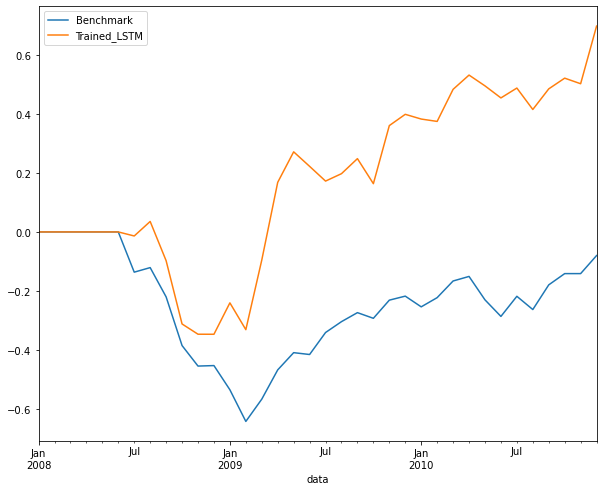

In [28]:
df = plotPortfolioReturns(d_res)

In [27]:
plotAllocation(ah.dropna())

In [30]:
getStatistic(d_stat).to_csv('Trained_Model_stat_2008_2010.csv')
df.to_csv('Trained_Model_drawdown_2008_2010.csv')

# TEST 2011-2017

In [29]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2011, 1, 1),
    'endd'  : datetime(2017, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="saved_model_1_078", model_nr=1),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [30]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Starting Portfolio Value: 11000.00
Final Portfolio Value: 40047.28


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,20.310959,15.706047,0.381097,40047.275846


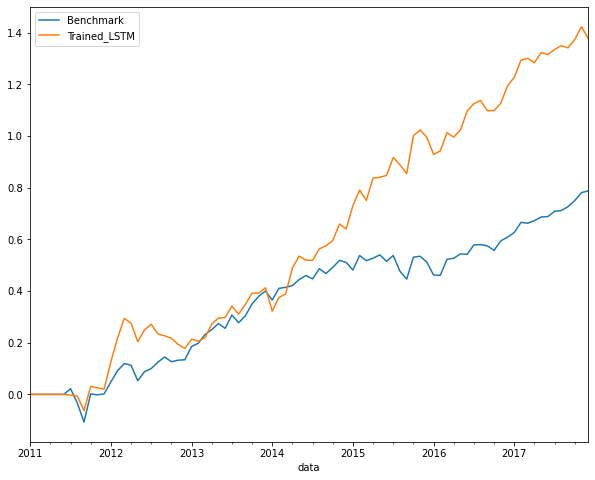

In [32]:
df = plotPortfolioReturns(d_res)

In [33]:
plotAllocation(ah.dropna())

In [34]:
getStatistic(d_stat).to_csv('Trained_Model_stat_2011_2017.csv')
df.to_csv('Trained_Model_drawdown_2011_2017.csv')

# Test 2018-2021

In [40]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2018, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="saved_model_1_078", model_nr=1),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [41]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Starting Portfolio Value: 11000.00
Final Portfolio Value: 19477.65


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,18.993179,28.977742,0.249069,19477.6527


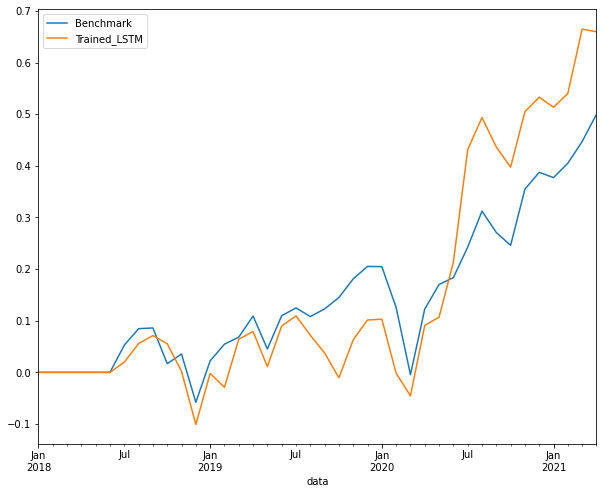

In [42]:
df = plotPortfolioReturns(d_res)

In [43]:
plotAllocation(ah.dropna())

In [44]:
getStatistic(d_stat).to_csv('Trained_Model_stat_2018_2021.csv')
df.to_csv('Trained_Model_drawdown_2018_2021.csv')

# 2012 - 2016


In [45]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2012, 1, 1),
    'endd'  : datetime(2016, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="saved_model_1_078", model_nr=1),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [46]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Starting Portfolio Value: 11000.00
Final Portfolio Value: 18364.03


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,10.81176,19.412764,0.228213,18364.034049


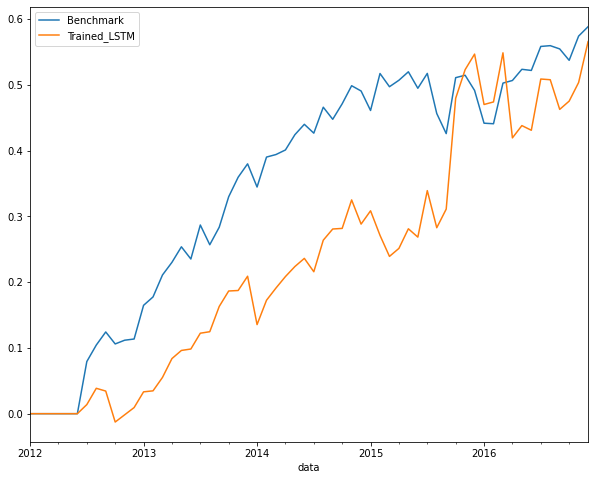

In [47]:
df = plotPortfolioReturns(d_res)

In [48]:
plotAllocation(ah.dropna())

In [49]:
getStatistic(d_stat).to_csv('Trained_Model_stat_2012_2016.csv')
df.to_csv('Trained_Model_drawdown_2012_2016.csv')

# 2016 - 2021
SPY, TLT, GLD, IYR

In [50]:
config_cerebro = {
    'assets':['SPY', 'TLT', 'GLD', 'RWO'],
    'benchmark':'SPY',
    'startd': datetime(2016, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="saved_model_etf_2010_2015"),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [51]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Starting Portfolio Value: 11000.00
Final Portfolio Value: 16377.17


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,7.826418,14.806694,0.233561,16377.166649


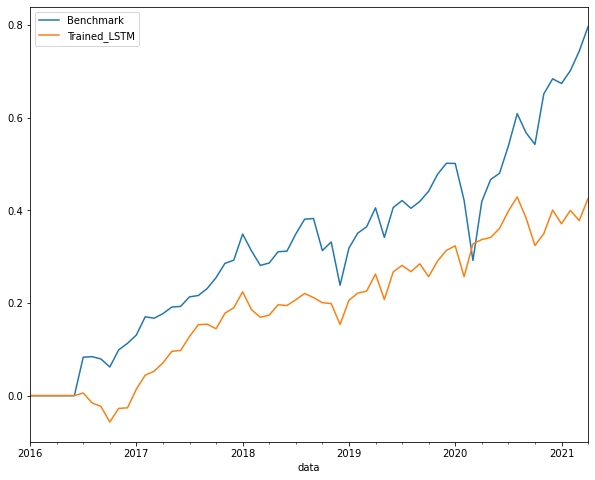

In [52]:
df = plotPortfolioReturns(d_res)

In [53]:
getStatistic(d_stat).to_csv('Trained_Lstm_stat_etf_2016_2021.csv')
df.to_csv('Trained_Lstm_drawdown_etf_2016_2021.csv')